In [310]:
# https://pypi.org/project/torch-geometric/
# pip install torch
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
# pip install torch-geometric


# https://towardsdatascience.com/louvains-algorithm-for-community-detection-in-python-95ff7f675306
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 一、Data Inclusion
<br>
先將 training data include 進來，可以使用 print 看一下 train_data 長甚麼樣子，基本上就是以下這個 format <p>circleID: friend1 friend2 friend3 ... <p/>

總共有57種 features<br>

In [37]:
import os

# Include Training dataset
target_dir = os.getcwd()+"\Training"

data = []
for filename in os.listdir(target_dir):
    with open(os.path.join(target_dir, filename), 'r') as f:
        data += f.readlines()

train_data = []
for i in range(len(data)):
    train_data.append(data[i].split()[1:]) # circle* is seems not nesseary

print(f"number of trainin data: {len(train_data)}")
    
    
    
# Total is 57 kinds of features

with open("featureList.txt", 'r') as f:
    feature_list = f.readlines()

for i in range(len(feature_list)):
    feature_list[i] = feature_list[i].replace('\n', '')

print(f"number of features : {len(feature_list)}")


number of trainin data: 592
number of features : 57


舉例:   
26321.circles 和 25773.circles 都有circle 10分別是  
26321.circles -> circle10: 26379 26455 26482 26340 26409 26366 26390 26477 26415 26462 26402  
25773.circles -> circle10: 25787 25924 25947 25836 25817 25857 25902 25815 25821 25774 25961 ...
  
應該要將同樣 circle 的 user 加在一起，因為他們都是同一個 circle  
  
在沒這樣做之前，circle會重複，所以會誤以為是 592個，但實際上應該是455個才對

In [177]:
# 先找出重複的circle有幾個，再針對他們做合併，應該比較快，就不用一個一個還要重複掃
tes = []
for i in range(len(data)):
    tes.append(data[i].split(':')[0])

a = Counter(tes).most_common()[:46] # 有重複的總共46個
b = []
for i in range(len(a)):
    b.append(a[i][0])
print(f"Show the fist 5 elements: {b[:5]}")
print(f"Actually circle numbers: {len(Counter(tes))} not {len(tes)}")

Show the fist 5 elements: ['circle13', 'circle18', 'circle62', 'circle10', 'circle74']
Actually circle numbers: 455 not 592


In [197]:
temp_a = []

for target in b:
    temp = []
    for i in range(len(data)):
        circle_name = data[i].split(':')[:1][0]
        if circle_name == target:
            temp += data[i].split()[1:]

    temp_a.append(temp)

for i in range(len(data)):
    circle_name = data[i].split(':')[:1][0]
    
    if circle_name not in b: #如果 circle name 沒有重複的名單中，加入到list中
        temp_a.append(data[i].split()[1:])
        
print(f"Examine if the number is correct : {len(temp_a)}. The answer is yes, we eliminate repeat cicles.")

Examine if the number is correct : 455. The answer is yes, we eliminate repeat cicles.


#### label每個node

In [299]:
# initialization every user's label
y_label = [0] * 27520

for i in range(len(temp_a)):
    for item in temp_a[i]:
        y_label[int(item)] = i+1

# 預想是說一個 user 應該會對應到一個 circle
# 但 0 特別多，代表有很多 user 沒有標到
# 下面 aaaa 是在算 train_data 中所有的 user，train_data代表將所有.circles的檔案合成一個list
#print(len(y_label)-Counter(y_label).most_common()[0][1])

aaaa = []
for i in train_data:
    aaaa+=i
#print(len(Counter(aaaa)))

11545
11545


#### Include 每個 Node 對應的 features，並且把它包成 DataFrame，但後續還需要做處理...<br>

In [300]:
# Include each user's features 
    
fea_dir = "features\\features.txt"
features = []

with open(fea_dir, 'r') as f:
    features += f.readlines()

a = [] 

for i in range(len(features)):
    # split each user features by space
    a.append(features[i].split()) 

final = []

# make a dict that key is feature and value is corresponeding value
for j in range(len(a)):
    b_col = []
    b_row = []
    for i in range(len(a[j][1:])):
        b_col.append(a[j][1:][i][::-1].split(';', 1)[1][::-1])
        b_row.append(a[j][1:][i].split(';')[-1])

    final.append(dict(zip(b_col, b_row)))
    
df = pd.DataFrame(final)
print(f"number of user:  {len(df)}")
#df # there are many NaN
df

number of user:  27520


,last_name,first_name,birthday,name,gender,locale,hometown;name,hometown;id,education;school;name,education;school;id,...,work;projects;from;name,work;projects;from;id,education;classes;description,work;from;name,work;from;id,political,religion,work;projects;end_date,work;projects;description,location
0,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1,1,0,1,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,2,1,0,2,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3,3,1,0,3,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,4,4,0,0,4,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27515,4416,3040,4794,27280,1,1,NaN,NaN,4174,22356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27516,17149,2944,NaN,27281,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27517,17150,470,NaN,27282,1,1,133,133,395,405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27518,17151,3002,3531,27283,0,8,4299,4313,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 合成 edge list

In [6]:
egonets = []
for filename in os.listdir(os.getcwd()+"\egonets"):
    with open(os.path.join(os.getcwd()+"\egonets", filename), 'r') as f:
        egonets += f.readlines()

In [70]:
num_of_user = len(df)
ego_net = egonets[:num_of_user]

res = []

for ego in ego_net:
    e1, es = ego.split(':')
    es = es.split()

    for e in es:
        res.append((int(e1), int(e)))
print(f"First 10 examples: ", res[:10])

First 10 examples:  [(1, 146), (1, 189), (1, 229), (1, 201), (1, 204), (1, 60), (1, 215), (1, 35), (1, 91), (1, 238)]


# 二、Data Preprocessing

之後可以在這裡做一些 feature selection 之類的、或者視覺化<br>
有一些 features 是 NaN，可以做一些處理

### 視覺化 data

In [308]:
num_of_user = 238
ego_net = egonets[:num_of_user]

res = []

for ego in ego_net:
    e1, es = ego.split(':')
    es = es.split()

    for e in es:
        res.append((int(e1), int(e)))

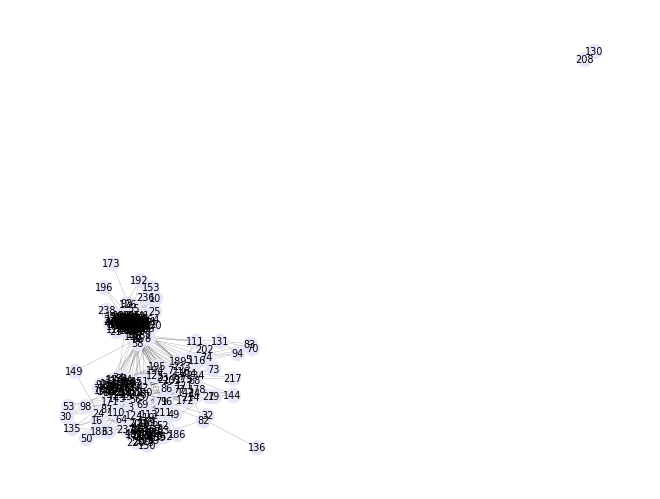

In [309]:
  # generation of a sample graph
G = nx.Graph()
G.add_edges_from(res)
  
# Defining ego as large and red
# while alters are in lavender
#ego = 1
pos = nx.spring_layout(G)
options = {
            "node_color": "lavender", 
            "node_size": 100,
            "with_labels": True,
            "font_size": 7,
            "width": 0.1,
          }
nx.draw(G, pos, **options)

# ego node below but likely useless in the case
# options = {"node_size": 100, "node_color": "r"}
# nx.draw_networkx_nodes(G, pos, nodelist=[ego], **options)
#plt.figure(figsize=(8, 6), dpi=80)
plt.show()

# 三、Model

In [4]:
dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)

In [5]:
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)